In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 30 10:13:51 2023

@author: jkelly3 & sduplessis
"""

#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from collections import  Counter

import re

import nltk
#nltk.download()

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

import string
#import contractions as cns

import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim.models
from sklearn.manifold import TSNE
#from adjustText import adjust_text

import xgboost as xgb

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [4]:
#Download corpora
def download_Data(file_location):

    '''
    Download and read a CSV file into a pandas DataFrame. Give the Function a string with the absolute path to your csv,
    or alternatively give it the name of the csv if the file is in the same directory as this script.

    Args:
    file_location (str) : The file path or URL of the CSV file to be downloaded and read.

    Returns:
    df (pandas.DataFrame) : A DataFrame containing the data read from the CSV file.

    '''

    return pd.read_csv(file_location)

In [5]:
# Testing on data
data_loc = '../Data/aggregated_data.csv'
df1 = download_Data(data_loc)
df1.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.394470e+12
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.394470e+12
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.394470e+12


### Data Exploration

In [7]:
print(f'There are {len(df1)} rows in the dataset.')

There are 422419 rows in the dataset.


### Category Count Bar Chart

In [8]:
#Exploratory Data Analysis

def barplot_target_category(df1, field, field_replacement_dict=None):

    '''
    Create a bar plot to visualize the counts of categories in a DataFrame column.

    Args:
        df1 (pandas.DataFrame): The original DataFrame.
        field (str): The name of the column in the DataFrame containing the categories to be plotted.
        field_replacement_dict (dict, optional): A dictionary to map category replacements if needed. Default is None.

    Returns:
        None
    '''

    df = df1.copy()

    if field_replacement_dict:
        df[field] = df[field].replace(field_replacement_dict)

    counts = df[field].value_counts()
    num_categories = len(counts)
    color_palette = plt.colormaps.get_cmap("tab10")  # Change 'tab10' to any other colormap you prefer

    # Create the bar plot
    plt.bar(counts.index, counts.values, color=color_palette(range(num_categories)))
    plt.plot()

    # Customize the plot
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Counts of Categories')
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()



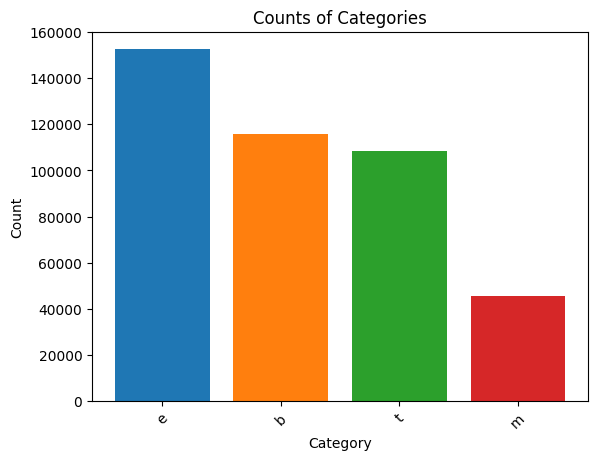

In [9]:
# Plot chart for data
field = 'CATEGORY'

barplot_target_category(df1, field, field_replacement_dict=None)

### Analysis of N-grams
This function retrieves the top n-grams (word sequences) from a corpus based on their frequency. This function can be called
on the unprocesesed target column or after processing.

Change n as required.

In [10]:
#Analysis of N-grams:

def _get_top_ngram(corpus, n=None):

    '''
    Get the top n-grams (word sequences) in a corpus based on their frequency.

    Args:
        corpus (list): A list of strings representing the text corpus.
        n (int, optional): The n-gram size. Default is None, which corresponds to unigrams (single words).

    Returns:
        list: A list of tuples containing the top n-grams and their frequencies.
    '''

    # Create a CountVectorizer object to convert text into a bag of words representation
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)

    # Transform the corpus into a bag of words
    bag_of_words = vec.transform(corpus)

    # Sum the word frequencies across the entire corpus
    sum_words = bag_of_words.sum(axis=0)

    # Create a list of tuples containing each n-gram and its frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort the list in descending order based on the n-gram frequency
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Return the top n-grams (defaulting to the top 10)
    return words_freq[:10]

# Plot the N-grams:

def plot_top_ngrams_barchart(text, n=2):

    '''
    Create a bar chart to visualize the top n-grams (word sequences) in the given text.

    Args:
        text (pandas.Series): A pandas Series containing the text data.
        n (int, optional): The n-gram size. Default is 2.

    Returns:
        None
    '''

    # Get the set of English stopwords
    stop = set(stopwords.words('english'))

    # Split the text into words and remove stopwords
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i if word not in stop]

    # Get the top n-grams using the _get_top_ngram function
    top_n_bigrams = _get_top_ngram(text, n)[:10]

    # Extract the n-grams and their frequencies from the result
    x, y = map(list, zip(*top_n_bigrams))

    # Create a bar plot using seaborn's barplot function
    sns.barplot(x=y, y=x)

    # Show the plot
    plt.show()

#plot_top_ngrams_barchart(df['TITLE'],2)

#plot_top_ngrams_barchart(df['CLEAN_TEXT'],3)


In [ ]:
# Required to download this, however it may not work - so may have to download manually here: https://www.nltk.org/data.html
# STILL HAVING ISSUES WITH THIS, SO LEAVE FOR NOW

# import nltk
# nltk.download()

#STACK OVERFLOW SOLUTION - https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed#:~:text=It%20means%20that%20you%20are,time%20dependencies%20for%20Python%20etc.&text=Should%20solve%20the%20issue.,modules%20in%20your%20docker%20file.

#ONLY RUN THIS ONCE, THEN COMMENT OUT

# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

: 

: 

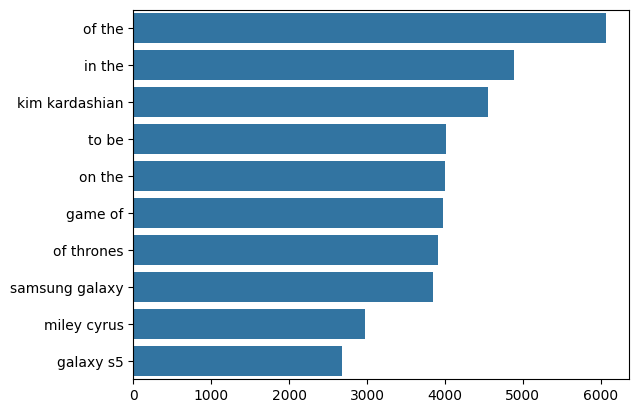

In [11]:
corpus = df1['TITLE'].astype(str).tolist()
text = df1['TITLE']

top_n = _get_top_ngram(corpus, n=2)
plot_top_n = plot_top_ngrams_barchart(text, n=2)

### Data Manipulation & Pre-processing

In [12]:
# Form Corpora from data
# Form the Corpora and Analyse frequency of non-stop words:
def form_corpora_list(df, field, is_list = False):

    '''
    Extract a corpus list from a DataFrame column. Give this function the pandas dataframe and the field/column that
    you are using to form the corpus of your analysis. If that column is tokenized e.g., in a list format, include the
    is_list flag as true, if it is a column of strings, make the flag false.

    Args:
    df (pandas.DataFrame) : The DataFrame containing the data.

    field (str) : The name of the column in the DataFrame from which the corpus will be extracted.

    is_list (bool), optional (default=False) :
        If True, assumes that the specified column contains lists of words.
        If False, assumes that the specified column contains sentences or text.

    Returns:
    list (list) : A list containing the words or elements from the specified column (corpus).
    '''

    if is_list:
        return df[field].explode().tolist()

    corpus = []
    column_split = df[field].str.split()
    column_split = column_split.values
    column_split_list = column_split.tolist()

    # Flatten nested Lists into one corpus list
    for i in column_split:
        for word in i:
            corpus.append(word)


    return corpus


In [13]:
content = 'TITLE'
corpora = form_corpora_list(df1, content, is_list = False)

In [14]:
# Outline Specific contractions to be applied to data
def specific_contractions():

    '''
    Get a dictionary of specific contractions and their corresponding replacements.

    Returns:
    general phrases (dict) : A dictionary containing regular expression patterns as keys and their corresponding replacements
    as values.

    '''

    GENERAL_PHRASES = {
        #covid
        r"\bcovid19\b": "covid",
        r"\bcovid 19\b": "covid",
        r"\bcoronavirus\b": "covid",
        r"\bcorona virus\b": "covid",
        r"\b[Uu]\.?[Ss]\.?'?s?\b ": "US ",
        r"\bU\.?K\.?\b" : "United Kingdom",
        r"&" : "and"}

    return GENERAL_PHRASES


## Replace the contractions in the text with their given expansions

In [15]:
def replace_custom_constractions(text):

    '''
    Replace specific contractions in the given text with their corresponding expansions.

    Args:
    text (str) : The input text where contractions will be replaced.

    Returns:
    text (str) : The input text with specific contractions replaced.

    '''

    dict_contractions = specific_contractions()

    for pattern, replacement in dict_contractions.items():
        text = re.sub(pattern, replacement, text)

    return text



In [17]:
modified_text = []

for i in range (len(text)):
    modified_text.append(replace_custom_constractions(text[i]))

text = modified_text

## Form set of stopwords

In [18]:
#Import stopwords
def custom_stopwords():

    '''
    Get a set of custom stopwords by combining NLTK's English stopwords with additional stopwords.

    Returns:
        set (set): A set containing custom stopwords for text processing.
    '''

    from nltk.corpus import stopwords
    stopwords = set(stopwords.words('english'))


    extra = set([])# Placeholder to include regular expressions and custom stopwords later

    stopwords = stopwords.union(extra)
    return stopwords

In [19]:
stopwords = custom_stopwords()
print(stopwords)

{'only', "wasn't", 'hasn', 'during', 'own', 'needn', 'herself', 'or', 'she', 'below', 'her', 'because', 'out', "she's", 'for', 'these', 'haven', 'before', 'your', 'those', 'an', 'nor', 'having', 'after', "shouldn't", 'to', 'aren', 'weren', "won't", 'shan', 'that', 'are', 'myself', "wouldn't", "should've", 're', 've', 'it', 'doing', 'above', 'm', "you're", 'very', 'shouldn', 'couldn', 'any', 'ma', "mustn't", 'theirs', 'i', 'where', 'such', 'now', 'all', 'why', 'be', 'am', "didn't", 'yours', 'again', 'when', 'mustn', 'our', 'we', 'ourselves', 'whom', 'further', 'then', 'themselves', 'ours', 'so', 'will', "needn't", 'not', 'hadn', 'is', 'o', 'himself', 'other', 'have', 'if', "isn't", 'while', 's', 'its', 'until', 'mightn', "shan't", 'were', 'from', 'how', 'there', 'ain', 'was', 'few', 'who', 'their', 'a', "don't", 'll', 'what', 'off', "hasn't", 'won', "mightn't", 'down', 'here', "aren't", 'most', 't', 'didn', "hadn't", 'just', 'y', 'them', 'doesn', "it's", "weren't", 'should', 'some', 'th

In [20]:
from textblob import TextBlob

def get_polarity(text):
    """
    Calculate the polarity (sentiment) of a given text using TextBlob.

    Args:
        text (str): The input text.

    Returns:
        float: The polarity score ranging from -1.0 (negative) to 1.0 (positive).
               If sentiment analysis fails, returns 0.0.
    """
    try:
        textblob = TextBlob(text)
        polarity = textblob.sentiment.polarity
    except:
        polarity = 0.0
    return polarity

def get_subjectivity(text):
    """
    Calculate the subjectivity of a given text using TextBlob.

    Args:
        text (str): The input text.

    Returns:
        float: The subjectivity score ranging from 0.0 (objective) to 1.0 (subjective).
               If sentiment analysis fails, returns 0.0.
    """
    try:
        textblob = TextBlob(text)
        subjectivity = textblob.sentiment.subjectivity
    except:
        subjectivity = 0.0
    return subjectivity


## Test Polarity & Subjectivirty Scoring

In [22]:
test_pol = get_polarity(text[0])
print(f'polarity: {test_pol}')
test_sub = get_subjectivity(text[0])
print(f'subjectivity: {test_sub}')

polarity: -0.11249999999999999
subjectivity: 0.5125


## Preprocessing function for Lemmatisation, stemming and rejoining strings

In [26]:
def pre_process(text, is_lemming = False, is_stemming = False, str_rejoin = False):

    '''
    Preprocess the text, giving options for lemmatization, stemming and rejoining string from list as optional flags.

    Args:
        text (str): The string input text that is being preprocessed.
        is_lemming (bool): The flag to control if the text should be lemmatized - default is False.
        is_stemming (bool): The flag to control if the text should be stemmed - default is False.
        str_rejoin (bool): The flag to control if the text should be rejoined from a list at the end of the preprocessing - default is False.

    Returns:
        str: A string with the preprocessed text.

    '''


    # Remove the basic contractions with the contractions package:
    text =  replace_custom_constractions(text)
    # text = cns.fix(text) # NOT SURE WHAT THE CNS PACKAGE IS HERE?

    # Remove 1st, 2nd, 3rd etc.:

    text = re.sub(r"\b\d+(st|nd|rd|th)\b", '', text)

    # Remove the Amounts of money e.g. 100k, 200M etc.:
    text = re.sub(r"\b\d+(\.\d+)?[kMBGTPEZY]\b", '', text)


    # Remove " 's " pattern:
    text = re.sub(r"\b\w+'s\b", '', text)

    # remove currency numbers:
    text = re.sub(r"[$€¥£]\d+[^ ]*", '', text)


    # Remove punctuation where the punctuation is internal - add space instead to maintain word breakpoint:
    pattern = r"(?<=\w)[!\"#$%&'()*+,-./:;<=>?@[\\\]^_`{|}~](?=\w)"
    text = re.sub(pattern, ' ', text)

    # Remove punctuation internal to words and replace with space
    text = re.sub(r"[^a-zA-Z0-9\s]+", '', text)

    # Remove Numbers:
    text =  re.sub(r'\d+', '', text)


    # Remove multiple spaces where they occur:
    text = re.sub(r'^\s+', '', text)
    text = re.sub(r'\s+', ' ', text)

    # Make the Text Lower
    text = text.lower()

    # Tokenize the text:
    text = nltk.word_tokenize(text)

    # Remove set of default stopwords with stopwords library:
    stop = custom_stopwords()
    text = [word for word in text if word not in stop]

    # Lemmatisation:
    if is_lemming:

        lem = WordNetLemmatizer()
        text = [lem.lemmatize(w) for w in text]

    # Stemming
    if is_stemming:

        ps = PorterStemmer()
        text = [ps.stem(w) for w in text]

    # If you want the tokens to be made back into a string:
    if str_rejoin:
        text = " ".join(text)


    return text


# Test on first headline

In [28]:
pre_processed_text = pre_process(text[0], is_lemming = False, is_stemming = False, str_rejoin = False)
print(pre_processed_text)

['fed', 'official', 'says', 'weak', 'data', 'caused', 'weather', 'slow', 'taper']


# Function to apply preprocessing to full df

In [34]:
def data_frame_pre_process(df_input, field, is_lemming = False, is_stemming = False, str_rejoin = False):

    '''
    Preprocess the text data in a DataFrame column.

    Args:
        df_input (pandas.DataFrame): The DataFrame containing the text data.
        field (str): The name of the column in the DataFrame containing the text data.
        is_lemming (bool): The flag to control if the text should be lemmatized - default is False.
        is_stemming (bool): The flag to control if the text should be stemmed - default is False.
        str_rejoin (bool): The flag to control if the text should be rejoined from a list at the end of the preprocessing - default is False.

    Returns:
        pandas.DataFrame: A DataFrame with the preprocessed text data in a new column named 'CLEAN_TEXT'.
    '''

    # Remove NA values from the dataset if present:
    df = df_input.dropna().copy()

    # Remove the basic contractions with the contractions package:
    df['CLEAN_TEXT'] = df[field].apply(lambda x: replace_custom_constractions(x))
    # df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x: cns.fix(x)) #NOT SURE WHAT THE CNS PACKAGE IS HERE?ß

    # Remove 1st, 2nd, 3rd etc.:

    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : re.sub(r"\b\d+(st|nd|rd|th)\b", '', x))

    # Remove the Amounts of money e.g. 100k, 200M etc.:
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : re.sub(r"\b\d+(\.\d+)?[kMBGTPEZY]\b", '', x))


    # Remove " 's " pattern:
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : re.sub(r"\b\w+'s\b", '', x))

    # remove currency numbers:
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : re.sub(r"[$€¥£]\d+[^ ]*", '', x))


    # Remove punctuation where the punctuation is internal - add space instead to maintain word breakpoint:
    pattern = r"(?<=\w)[!\"#$%&'()*+,-./:;<=>?@[\\\]^_`{|}~](?=\w)"
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x: re.sub(pattern, ' ', x))

    # Remove punctuation internal to words and replace with space
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : re.sub(r"[^a-zA-Z0-9\s]+", '', x))

    # Remove Numbers:
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : re.sub(r'\d+', '', x))


    # Remove multiple spaces where they occur:
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : re.sub(r'^\s+', '', x))
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : re.sub(r'\s+', ' ', x))

    # Make the Text Lower
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : x.lower())

    # Tokenize the text:
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : nltk.word_tokenize(x))

    # Remove set of default stopwords with stopwords library:
    stop = custom_stopwords()
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : [word for word in x if word not in stop])

    # Lemmatisation:
    if is_lemming:

        lem = WordNetLemmatizer()
        df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : [lem.lemmatize(w) for w in x])

    # Stemming
    if is_stemming:

        ps = PorterStemmer()
        df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : [ps.stem(w) for w in x])

    # If you want the tokens to be made back into a string:
    if str_rejoin:
        df['CLEAN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x : " ".join(x))

    return df

In [35]:
field = 'TITLE'
df = data_frame_pre_process(df1, field, is_lemming = False, is_stemming = False, str_rejoin = False)

# Feature Engineering Function - deemed not necessary for this task

In [30]:
def feature_engineer(df,target, unwanted = False):

    """
    Perform feature engineering on the given DataFrame for increased accuracy in classification.

    Args:
        df (pandas.DataFrame): The DataFrame containing pre-processed text data.
        target (str): The String name of the target categorical Label.
        unwanted (list): The list of unwanted columns Strings to drop

    Returns:
        X (pandas.DataFrame): The DataFrame with added features based on feature engineering.
        Y (np.array): Label Encoding of Categorical Target

    Note:
        This function adds various features to the DataFrame including word count, character count,
        diversity score, punctuation count, polarity, subjectivity, counts of specific parts of speech (POS) tags,
        and more.

    """
    y = df[target]


    # Feature Engineering for increased accuracy in classification:
    # Now we have processed and pre-processed text in our dataframe. Let's start making features from the above data.
    if unwanted:
        unwanted.append(target)
        X = df.drop(unwanted, axis = 1)

    # Feature 1 - Length of the input OR count of the words in the statement (Vocab size).
    X['WORD_COUNT'] = X['TITLE'].apply(lambda x: len(str(x).split()))  # Feature 1

    # Feature 2 - Count of characters in a statement
    X['CHARACTER_COUNT'] = X['TITLE'].apply(lambda x: len(str(x)))  # Feature 2

    # Feature 3 - Diversity_score i.e. Average length of words used in statement
    X['AVERAGE_LENGTH'] = X['CHARACTER_COUNT'] / X['WORD_COUNT']  # Feature 3

    # Feature 4: Count of punctuations in the input.
    X['PUNCTUATION_COUNT'] = X['TITLE'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))  # Feature 4

    # Change df_small to df to create these features on the complete dataframe
    X['polarity'] = X['TITLE'].apply(get_polarity)  # Feature 5: Polarity
    X['subjectivity'] = X['TITLE'].apply(get_subjectivity)  # Feature 6: Subjectivity

    # Tokenize all text without stopwords
    all_text_without_sw = ''
    for i in df.itertuples():
        all_text_without_sw = all_text_without_sw + str(i.TITLE)

    tokenized_all_text = word_tokenize(all_text_without_sw)  # tokenize the text

    # Adding POS Tags to tokenized words
    list_of_tagged_words = nltk.pos_tag(tokenized_all_text)
    set_pos = set(list_of_tagged_words)  # set of POS tags & words

    # Counting specific POS tags
    nouns = ['NN', 'NNS', 'NNP', 'NNPS']  # POS tags of nouns
    list_of_words = set(map(lambda tuple_2: tuple_2[0], filter(lambda tuple_2: tuple_2[1] in nouns, set_pos)))
    X['NOUN'] = X['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]))  # Feature 7

    # Counting pronouns
    pronouns = ['PRP', 'PRP$', 'WP', 'WP$']  # POS tags of pronouns
    list_of_words = set(map(lambda tuple_2: tuple_2[0], filter(lambda tuple_2: tuple_2[1] in pronouns, set_pos)))
    df['PRONOUN_COUNT'] = df['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]))  # Feature 8

    # Counting verbs
    verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']  # POS tags of verbs
    list_of_words = set(map(lambda tuple_2: tuple_2[0], filter(lambda tuple_2: tuple_2[1] in verbs, set_pos)))
    X['VERBS_COUNT'] = X['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]))  # Feature 9

    # Counting adverbs
    adverbs = ['RB', 'RBR', 'RBS', 'WRB']  # POS tags of adverbs
    list_of_words = set(map(lambda tuple_2: tuple_2[0], filter(lambda tuple_2: tuple_2[1] in adverbs, set_pos)))
    X['ADVERBS_COUNT'] = X['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]))  # Feature 10

    # Counting adjectives
    adjectives = ['JJ', 'JJR', 'JJS']  # POS tags of adjectives
    list_of_words = set(map(lambda tuple_2: tuple_2[0], filter(lambda tuple_2: tuple_2[1] in adjectives, set_pos)))
    X['ADJECTIVE_COUNT'] = X['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]))  # Feature 11

    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

    return X,y

# Data Exploartion after pre-processing

# Word Frequency Analysis

In [36]:
# Word Frequency Analysis without stopwords:

def word_frequency_analysis(df, field, amount, is_list = False, dict_wanted = False):

    '''
    Perform word frequency analysis on a corpus in a DataFrame column and visualize the results.

    Args:
        df (pandas.DataFrame): The DataFrame containing the text data.
        field (str): The name of the column in the DataFrame containing the text data.
        amount (int or 'all'): The number of most common words to analyze. Set to 'all' for all words.
        is_list (bool, optional): Set to True if the specified column contains lists of words. Default is False.
        dict_wanted (bool, optional): Set to True to return a dictionary of word frequencies. Default is False.

    Returns:
        None or dict: If dict_wanted is True, returns a dictionary of word frequencies. Otherwise, displays a bar plot.
    '''

    corpus = form_corpora_list(df, field, is_list)

    # Count most common words in the corpus
    counter = Counter(corpus)
    most_common_list = counter.most_common()

    # Initialize lists to store word and frequency information
    list_a, list_b = [], []

    # Determine the range for analysis based on 'amount' parameter
    if amount == 'all':
        range_limit = len(most_common_list)
    else:
        range_limit = amount

    # Extract word and frequency information based on range_limit
    for word, count in most_common_list[:range_limit]:
        list_a.append(word)
        list_b.append(count)

    # Check if a dictionary of word frequencies is wanted
    if dict_wanted:
        return {list_a[i]: list_b[i] for i in range(len(list_a))}

    # Create a bar plot using seaborn's barplot function
    sns.barplot(x=list_b, y=list_a)
    plt.show()

In [38]:
# Computationally Heavy
field = 'TITLE'
amount = 'all'

word_frequency_analysis(df, field, amount, is_list = False, dict_wanted = False)

# Function to retrieve frequency of specific words - if required

In [ ]:
def Word_frequency_request(df, field, test_list = [], is_list = False):

    '''
    Perform word frequency analysis on a corpus in a DataFrame column and display the frequency of specific words
    using a dictionary.

    Args:
        df (pandas.DataFrame): The DataFrame containing the text data.
        field (str): The name of the column in the DataFrame containing the text data.
        test_list (list, optional): A list of words to check the frequency for. Default is an empty list.
        is_list (bool, optional): Set to True if the specified column contains lists of words. Default is False (for strings).

    Returns:
        None
    '''

    word_dict = word_frequency_analysis(df, field, all, is_list, True)

    for word in test_list:

        if word in word_dict.keys():
            print(f"Frequency of {word}: {word_dict[word]}")

        else:
            print(f"{word} is not present in this corpus")


# Sentiment Analysis Function (VADER)

In [ ]:
#Sentiment analysis

def sentiment_vader(text, sid):

    """
    Analyze the sentiment of a given text using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool.

    Args:
        text (str): The input text for sentiment analysis.
        sid (nltk.sentiment.vader.SentimentIntensityAnalyzer): The VADER SentimentIntensityAnalyzer instance.

    Returns:
        str: The sentiment label with the highest score from the VADER analysis (either 'pos', 'neg', or 'neu').
    """

    # Polarity score returns dictionary
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)


def plot_sentiment_barchart(text):

    """
    Plot a bar chart to visualize the distribution of sentiments in the given text data.

    Args:
        text (pandas.Series): A pandas Series containing the text data.

    Returns:
        None
    """
    # Initialize the VADER SentimentIntensityAnalyzer - #nltk.download('vader_lexicon') if necessary:
    sid = SentimentIntensityAnalyzer()

    # Analyze sentiment for each text using the sentiment_vader function
    sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))

    # Create a bar plot to visualize the sentiment distribution
    plt.bar(sentiment.value_counts().index, sentiment.value_counts())


#plot_sentiment_barchart(df_test['CLEAN_TEXT'])